In [32]:
# Standard imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set style
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette('husl')
%matplotlib inline

# Display settings
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 100)

In [ ]:
# Load data
train_df = pd.read_csv('Quentin/dsba-m-1-challenge-purchase-prediction/train_dataset_M1_with_id.csv')
test_df = pd.read_csv('/Users/quentinvillet/oracles_of_paris/kaggle_competition/Quentin/dsba-m-1-challenge-purchase-prediction/test_dataset_M1_with_id.csv')

print(f"Training set shape: {train_df.shape}")
print(f"Test set shape: {test_df.shape}")

Training set shape: (13735, 22)
Test set shape: (6265, 21)


In [34]:
# Check for missing values
missing = train_df.isnull().sum()
missing_pct = 100 * missing / len(train_df)
missing_df = pd.DataFrame({'Missing_Count': missing, 'Percentage': missing_pct})
missing_df[missing_df['Missing_Count'] > 0].sort_values('Missing_Count', ascending=False)

,Missing_Count,Percentage
Age,2087,15.194758
Payment_Method,2052,14.939934
Referral_Source,2021,14.714234
Price,634,4.615945
Reviews_Read,291,2.118675
Category,287,2.089552
Price_Sine,284,2.067710
Session_ID,280,2.038588
Items_In_Cart,280,2.038588
Time_of_Day,279,2.031307


In [35]:
# Check for duplicates
duplicates = train_df.duplicated().sum()
print(f"Number of duplicate rows: {duplicates}")
print(f"Number of unique Session_IDs: {train_df['Session_ID'].nunique()}")

Number of duplicate rows: 0
Number of unique Session_IDs: 13455


In [36]:
# Purchase rate
purchase_rate = train_df['Purchase'].mean()
print(f"Overall purchase rate: {purchase_rate:.2%}")
print(f"\nPurchase distribution:")
print(train_df['Purchase'].value_counts())
print(f"\nPurchase distribution (%):")
print(train_df['Purchase'].value_counts(normalize=True) * 100)

Overall purchase rate: 36.81%

Purchase distribution:
0    8679
1    5056
Name: Purchase, dtype: int64

Purchase distribution (%):
0    63.188933
1    36.811067
Name: Purchase, dtype: float64


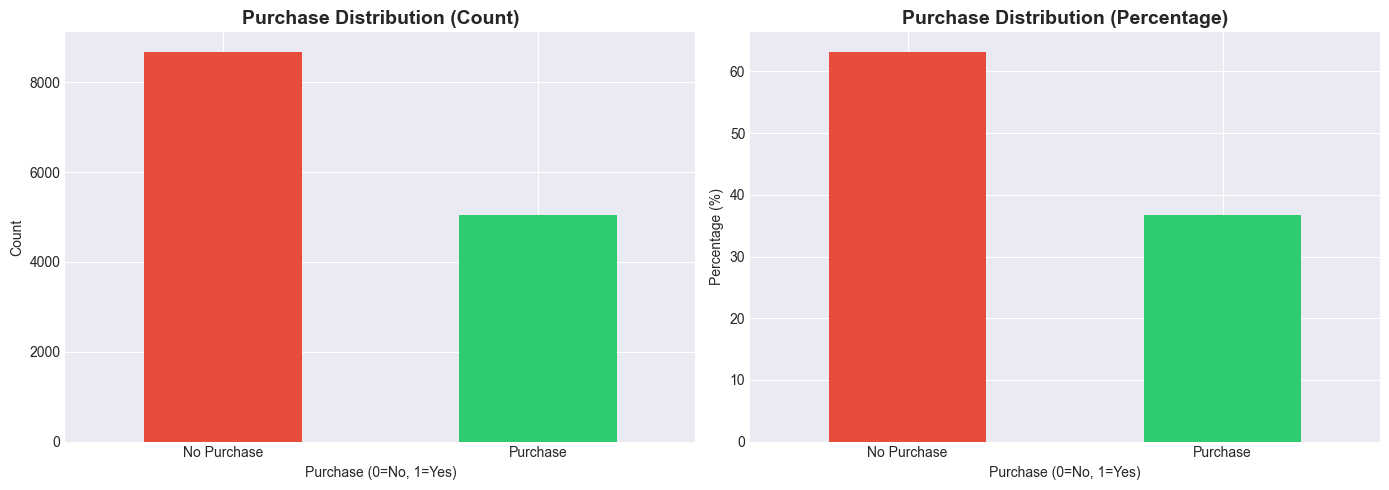


⚠️ Class imbalance: 1.7:1 ratio (No Purchase : Purchase)


In [37]:
# Visualize target distribution
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Count plot
train_df['Purchase'].value_counts().plot(kind='bar', ax=axes[0], color=['#e74c3c', '#2ecc71'])
axes[0].set_title('Purchase Distribution (Count)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Purchase (0=No, 1=Yes)')
axes[0].set_ylabel('Count')
axes[0].set_xticklabels(['No Purchase', 'Purchase'], rotation=0)

# Percentage plot
(train_df['Purchase'].value_counts(normalize=True) * 100).plot(kind='bar', ax=axes[1], color=['#e74c3c', '#2ecc71'])
axes[1].set_title('Purchase Distribution (Percentage)', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Purchase (0=No, 1=Yes)')
axes[1].set_ylabel('Percentage (%)')
axes[1].set_xticklabels(['No Purchase', 'Purchase'], rotation=0)

plt.tight_layout()
plt.show()

print(f"\n⚠️ Class imbalance: {(1 - purchase_rate) / purchase_rate:.1f}:1 ratio (No Purchase : Purchase)")

In [38]:
# Purchase rate by campaign period
campaign_purchase = train_df.groupby('Campaign_Period')['Purchase'].agg(['mean', 'count'])
campaign_purchase.columns = ['Purchase_Rate', 'Count']
campaign_purchase['Purchase_Rate'] = campaign_purchase['Purchase_Rate'] * 100
print("Purchase rate by Campaign Period:")
print(campaign_purchase)

Purchase rate by Campaign Period:
                 Purchase_Rate  Count
Campaign_Period                      
False                32.937441   8504
True                 43.387846   4953


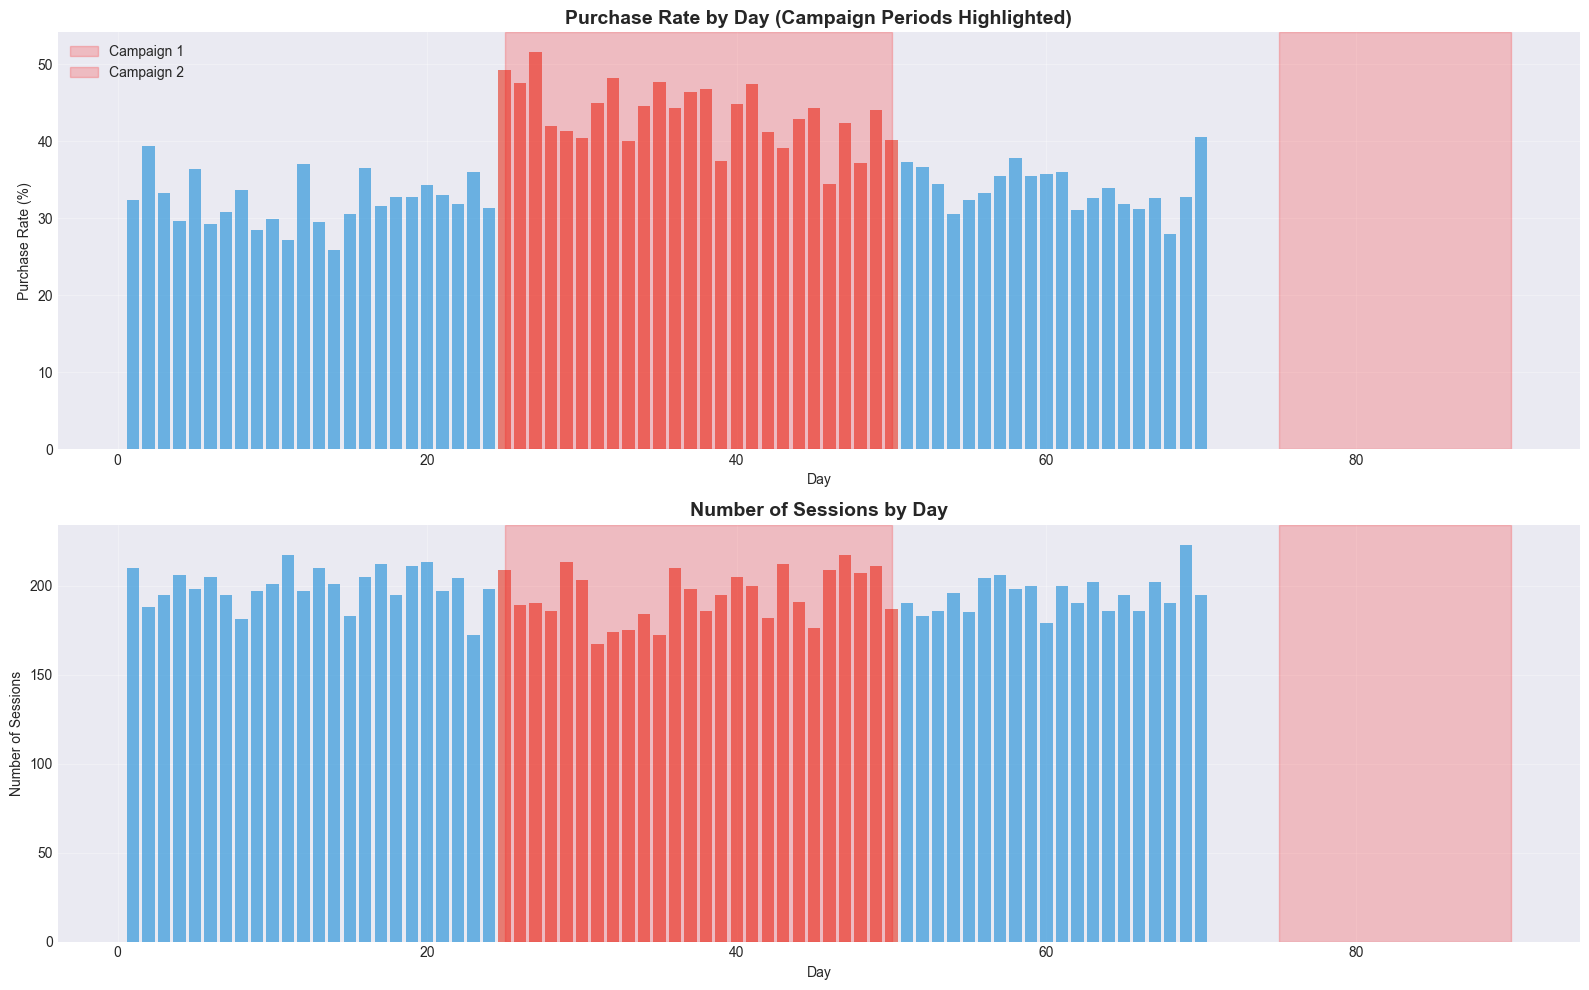

In [39]:
# Purchase rate over days
daily_stats = train_df.groupby('Day').agg({
    'Purchase': ['mean', 'count'],
    'Campaign_Period': 'first'
}).reset_index()
daily_stats.columns = ['Day', 'Purchase_Rate', 'Sessions', 'Campaign_Period']
daily_stats['Purchase_Rate'] = daily_stats['Purchase_Rate'] * 100

# Visualize
fig, axes = plt.subplots(2, 1, figsize=(16, 10))

# Purchase rate by day
colors = ['#e74c3c' if cp else '#3498db' for cp in daily_stats['Campaign_Period']]
axes[0].bar(daily_stats['Day'], daily_stats['Purchase_Rate'], color=colors, alpha=0.7)
axes[0].axvspan(25, 50, alpha=0.2, color='red', label='Campaign 1')
axes[0].axvspan(75, 90, alpha=0.2, color='red', label='Campaign 2')
axes[0].set_title('Purchase Rate by Day (Campaign Periods Highlighted)', fontsize=14, fontweight='bold')
axes[0].set_xlabel('Day')
axes[0].set_ylabel('Purchase Rate (%)')
axes[0].legend()
axes[0].grid(True, alpha=0.3)

# Sessions per day
axes[1].bar(daily_stats['Day'], daily_stats['Sessions'], color=colors, alpha=0.7)
axes[1].axvspan(25, 50, alpha=0.2, color='red')
axes[1].axvspan(75, 90, alpha=0.2, color='red')
axes[1].set_title('Number of Sessions by Day', fontsize=14, fontweight='bold')
axes[1].set_xlabel('Day')
axes[1].set_ylabel('Number of Sessions')
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

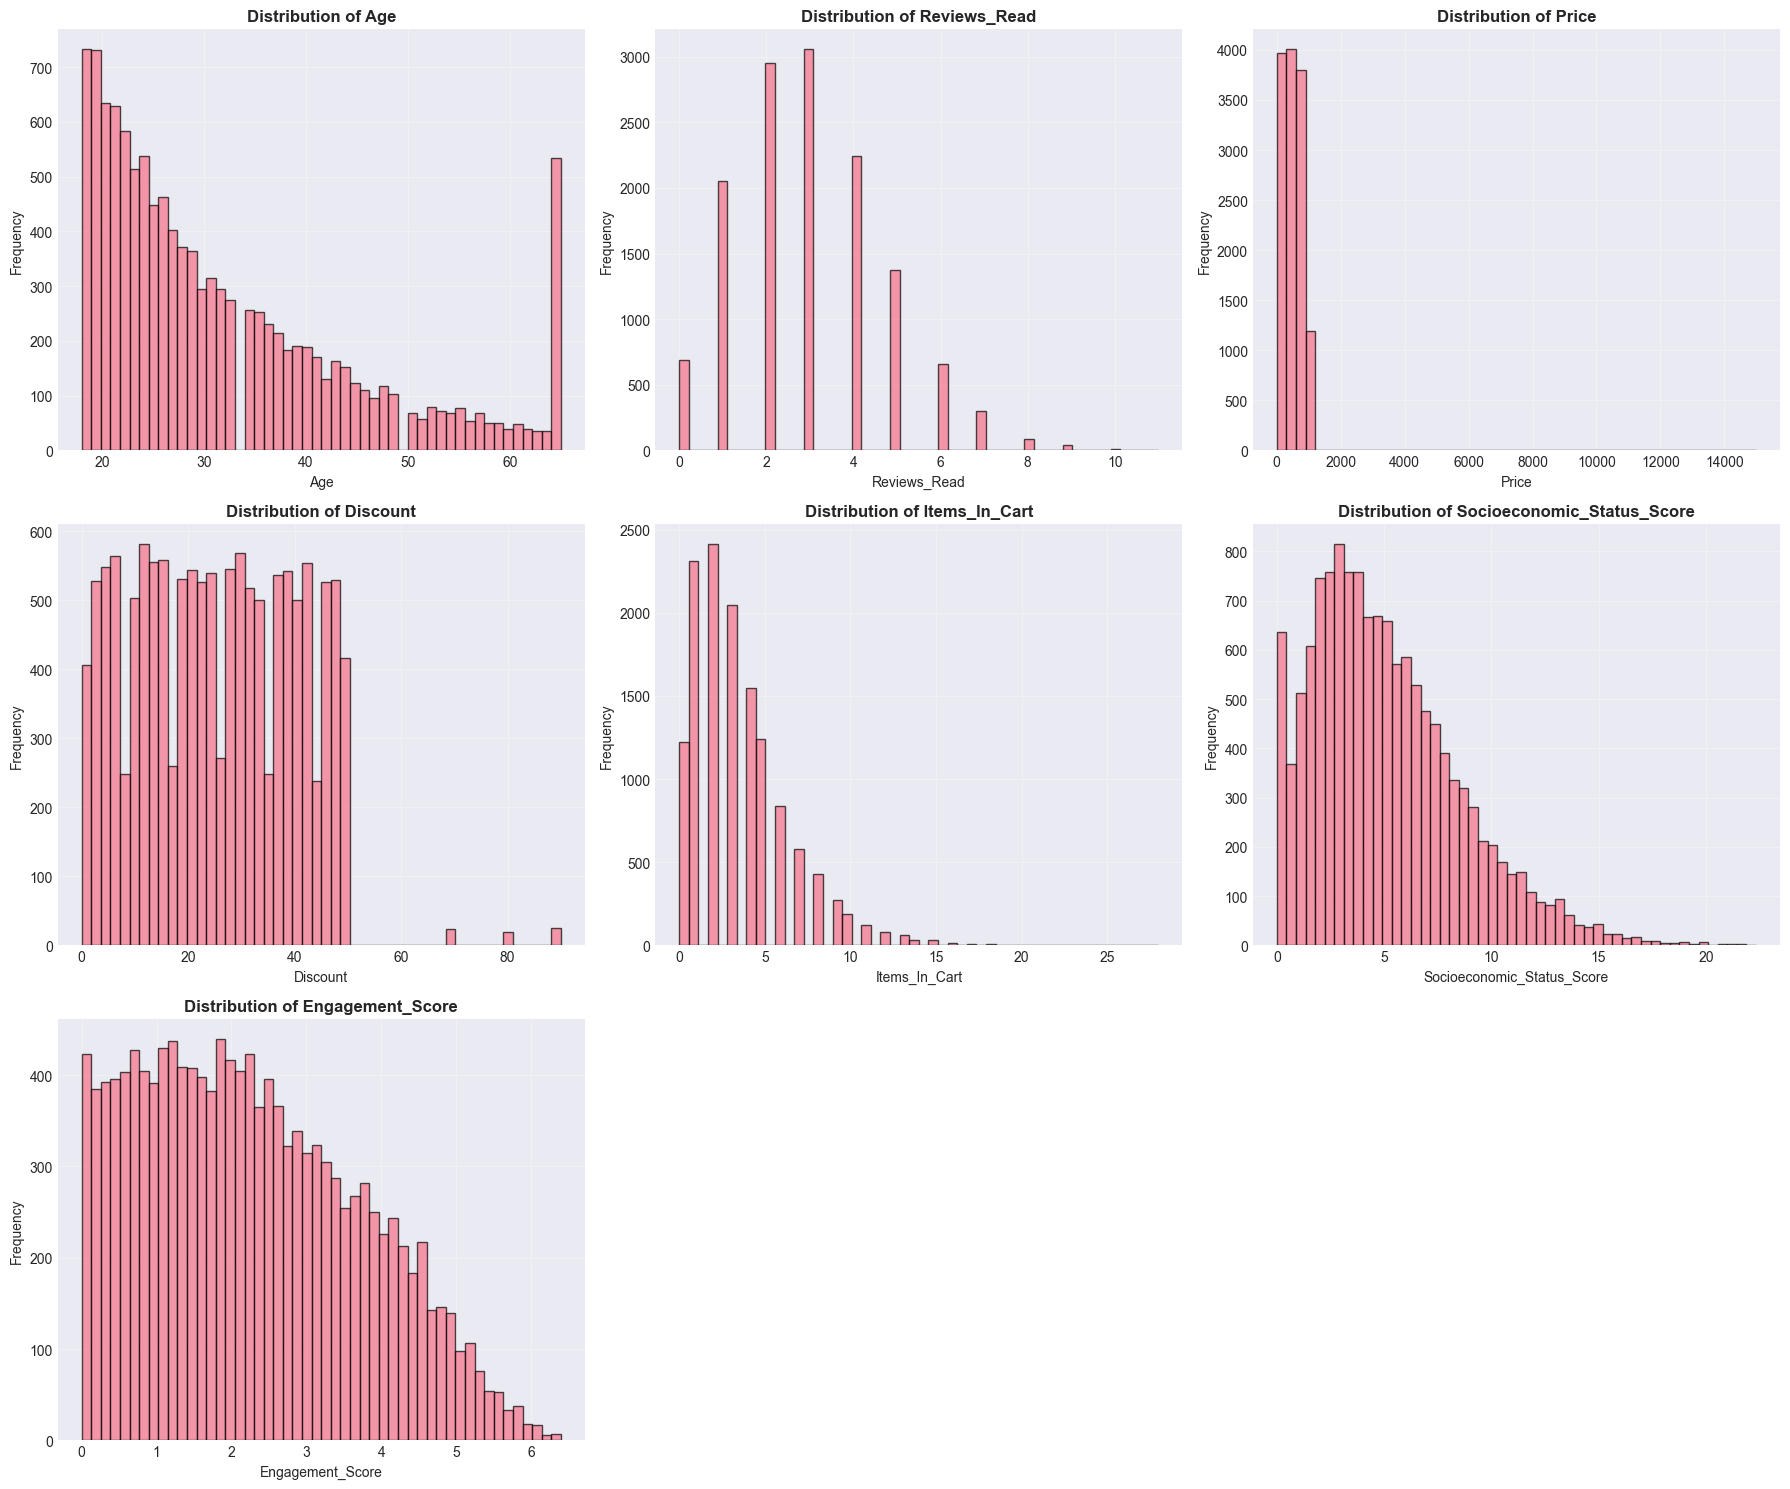

In [40]:
# Identify numerical features
numerical_features = ['Age', 'Reviews_Read', 'Price', 'Discount', 'Items_In_Cart',
                      'Socioeconomic_Status_Score', 'Engagement_Score']

# Distribution plots
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    axes[idx].hist(train_df[col], bins=50, edgecolor='black', alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Frequency')
    axes[idx].grid(True, alpha=0.3)

# Remove extra subplots
for idx in range(len(numerical_features), 9):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

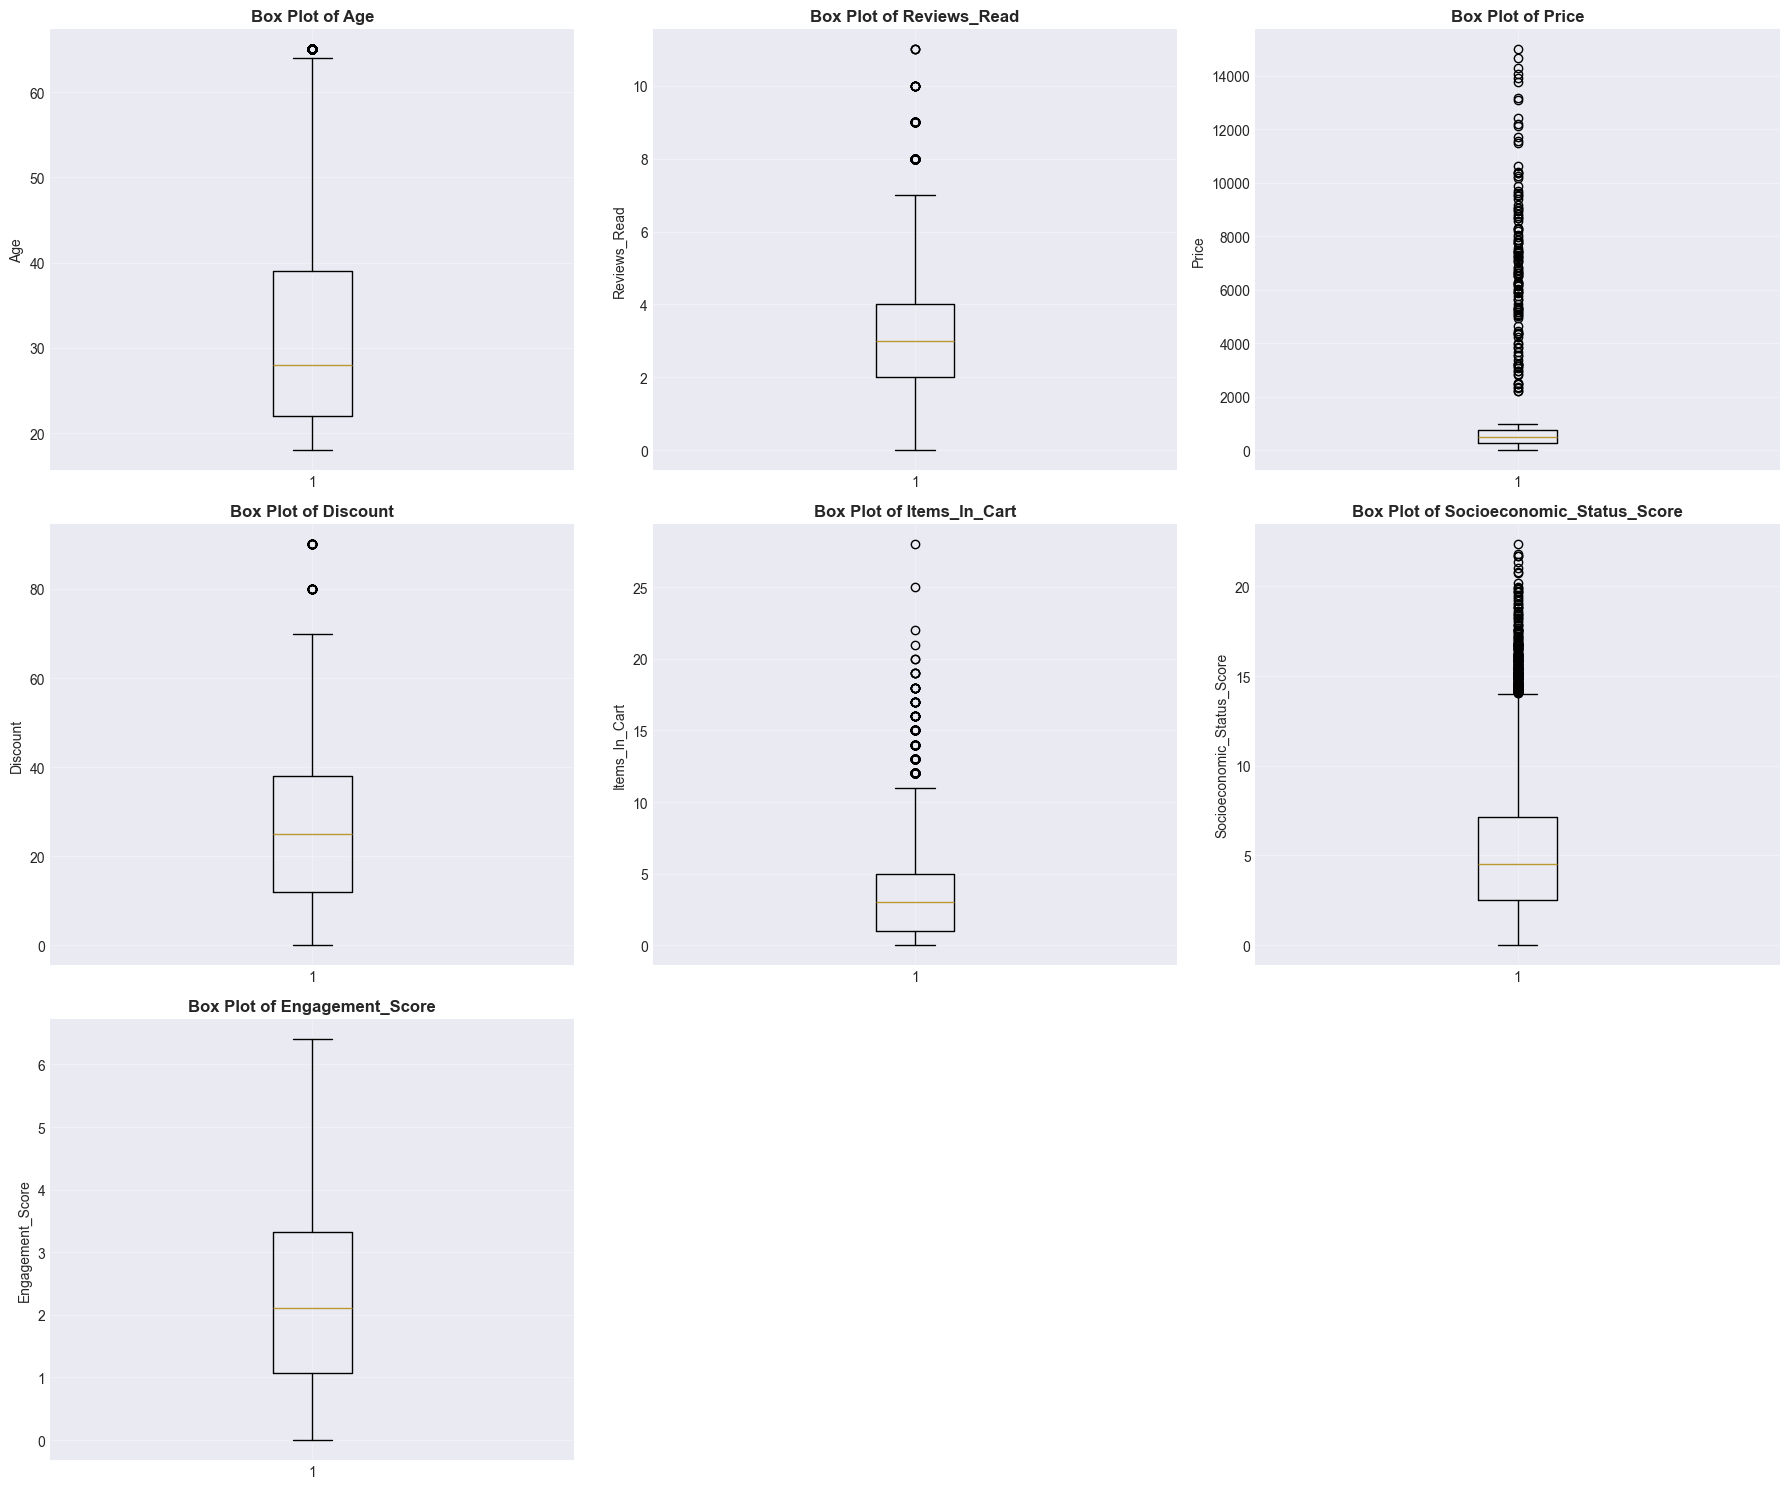

In [41]:
# Box plots to identify outliers
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    axes[idx].boxplot(train_df[col].dropna())
    axes[idx].set_title(f'Box Plot of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_ylabel(col)
    axes[idx].grid(True, alpha=0.3)

for idx in range(len(numerical_features), 9):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [42]:
# Categorical features
categorical_features = ['Gender', 'Category', 'Time_of_Day', 'Email_Interaction',
                        'Device_Type', 'Payment_Method', 'Referral_Source']

# Value counts for each categorical feature
for col in categorical_features:
    print(f"\n{'='*60}")
    print(f"{col} - Value Counts:")
    print('='*60)
    print(train_df[col].value_counts())
    print(f"\nPercentage distribution:")
    print(train_df[col].value_counts(normalize=True) * 100)


Gender - Value Counts:
0.0    6823
1.0    6652
Name: Gender, dtype: int64

Percentage distribution:
0.0    50.634508
1.0    49.365492
Name: Gender, dtype: float64

Category - Value Counts:
1.0    2778
4.0    2771
0.0    2690
3.0    2612
2.0    2597
Name: Category, dtype: int64

Percentage distribution:
1.0    20.657347
4.0    20.605294
0.0    20.002974
3.0    19.422963
2.0    19.311422
Name: Category, dtype: float64

Time_of_Day - Value Counts:
evening      5334
morning      4039
afternoon    3991
afterno0n       7
eveninG         5
eveniNg         5
Morning         4
eVening         4
eveNing         3
Afternoon       3
moRning         3
evenIng         3
Evening         3
aftern0on       3
evEning         2
afTern0on       2
mOrning         2
m0rning         2
evEnIng         2
morniNg         2
aFtern0on       1
afTErnoon       1
AfTernoOn       1
M0rnInG         1
afternooN       1
AFternoon       1
afTernoOn       1
evEninG         1
AfTernoon       1
eVEning         1
afternO0N 

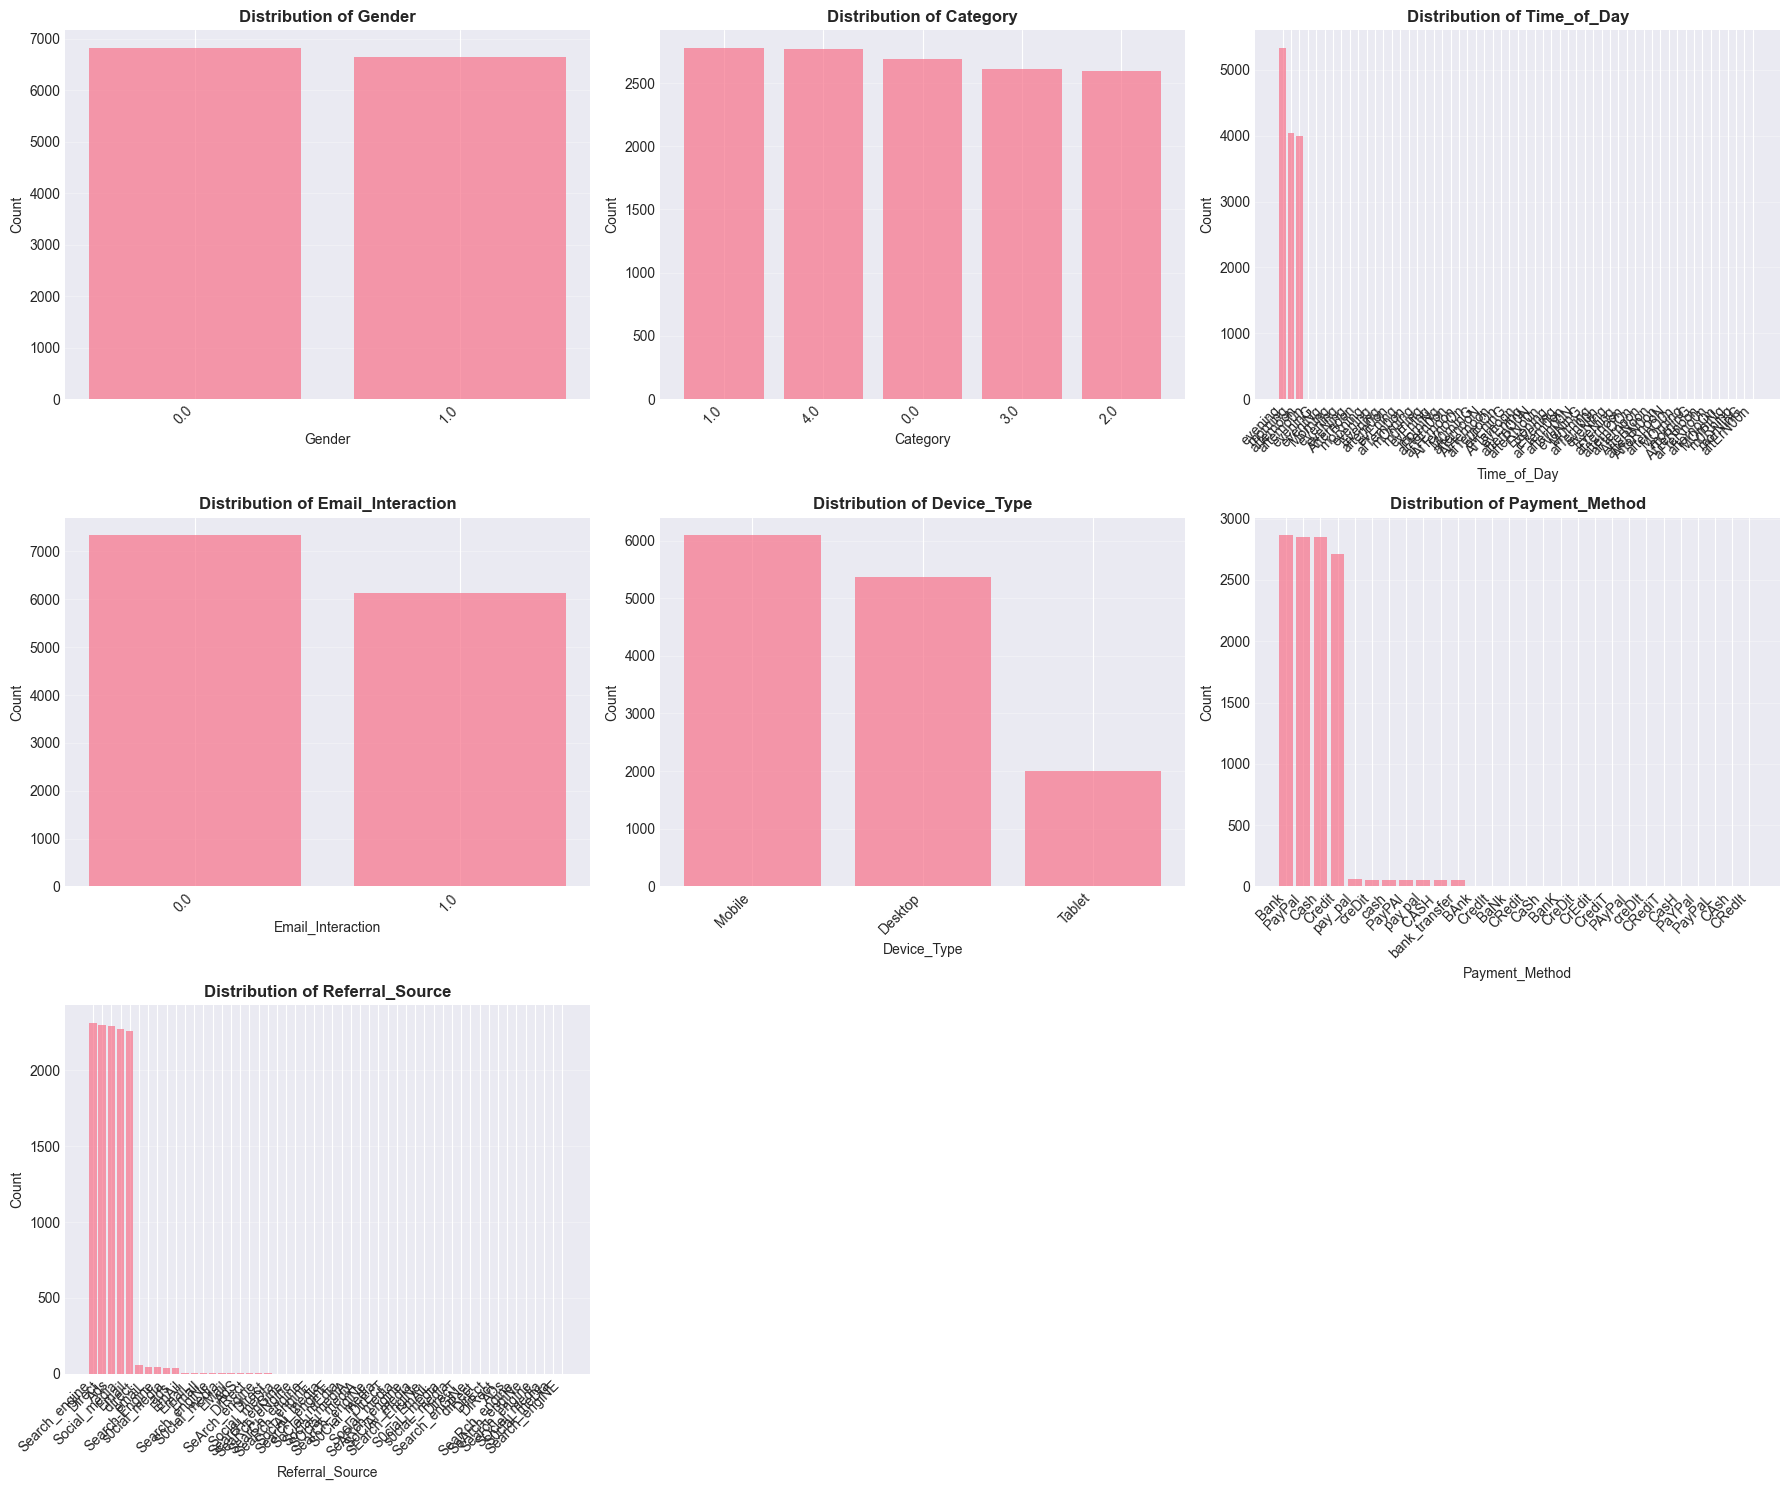

In [43]:
# Visualize categorical distributions
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    value_counts = train_df[col].value_counts()
    axes[idx].bar(range(len(value_counts)), value_counts.values, alpha=0.7)
    axes[idx].set_title(f'Distribution of {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Count')
    axes[idx].set_xticks(range(len(value_counts)))
    axes[idx].set_xticklabels(value_counts.index, rotation=45, ha='right')
    axes[idx].grid(True, alpha=0.3, axis='y')

for idx in range(len(categorical_features), 9):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

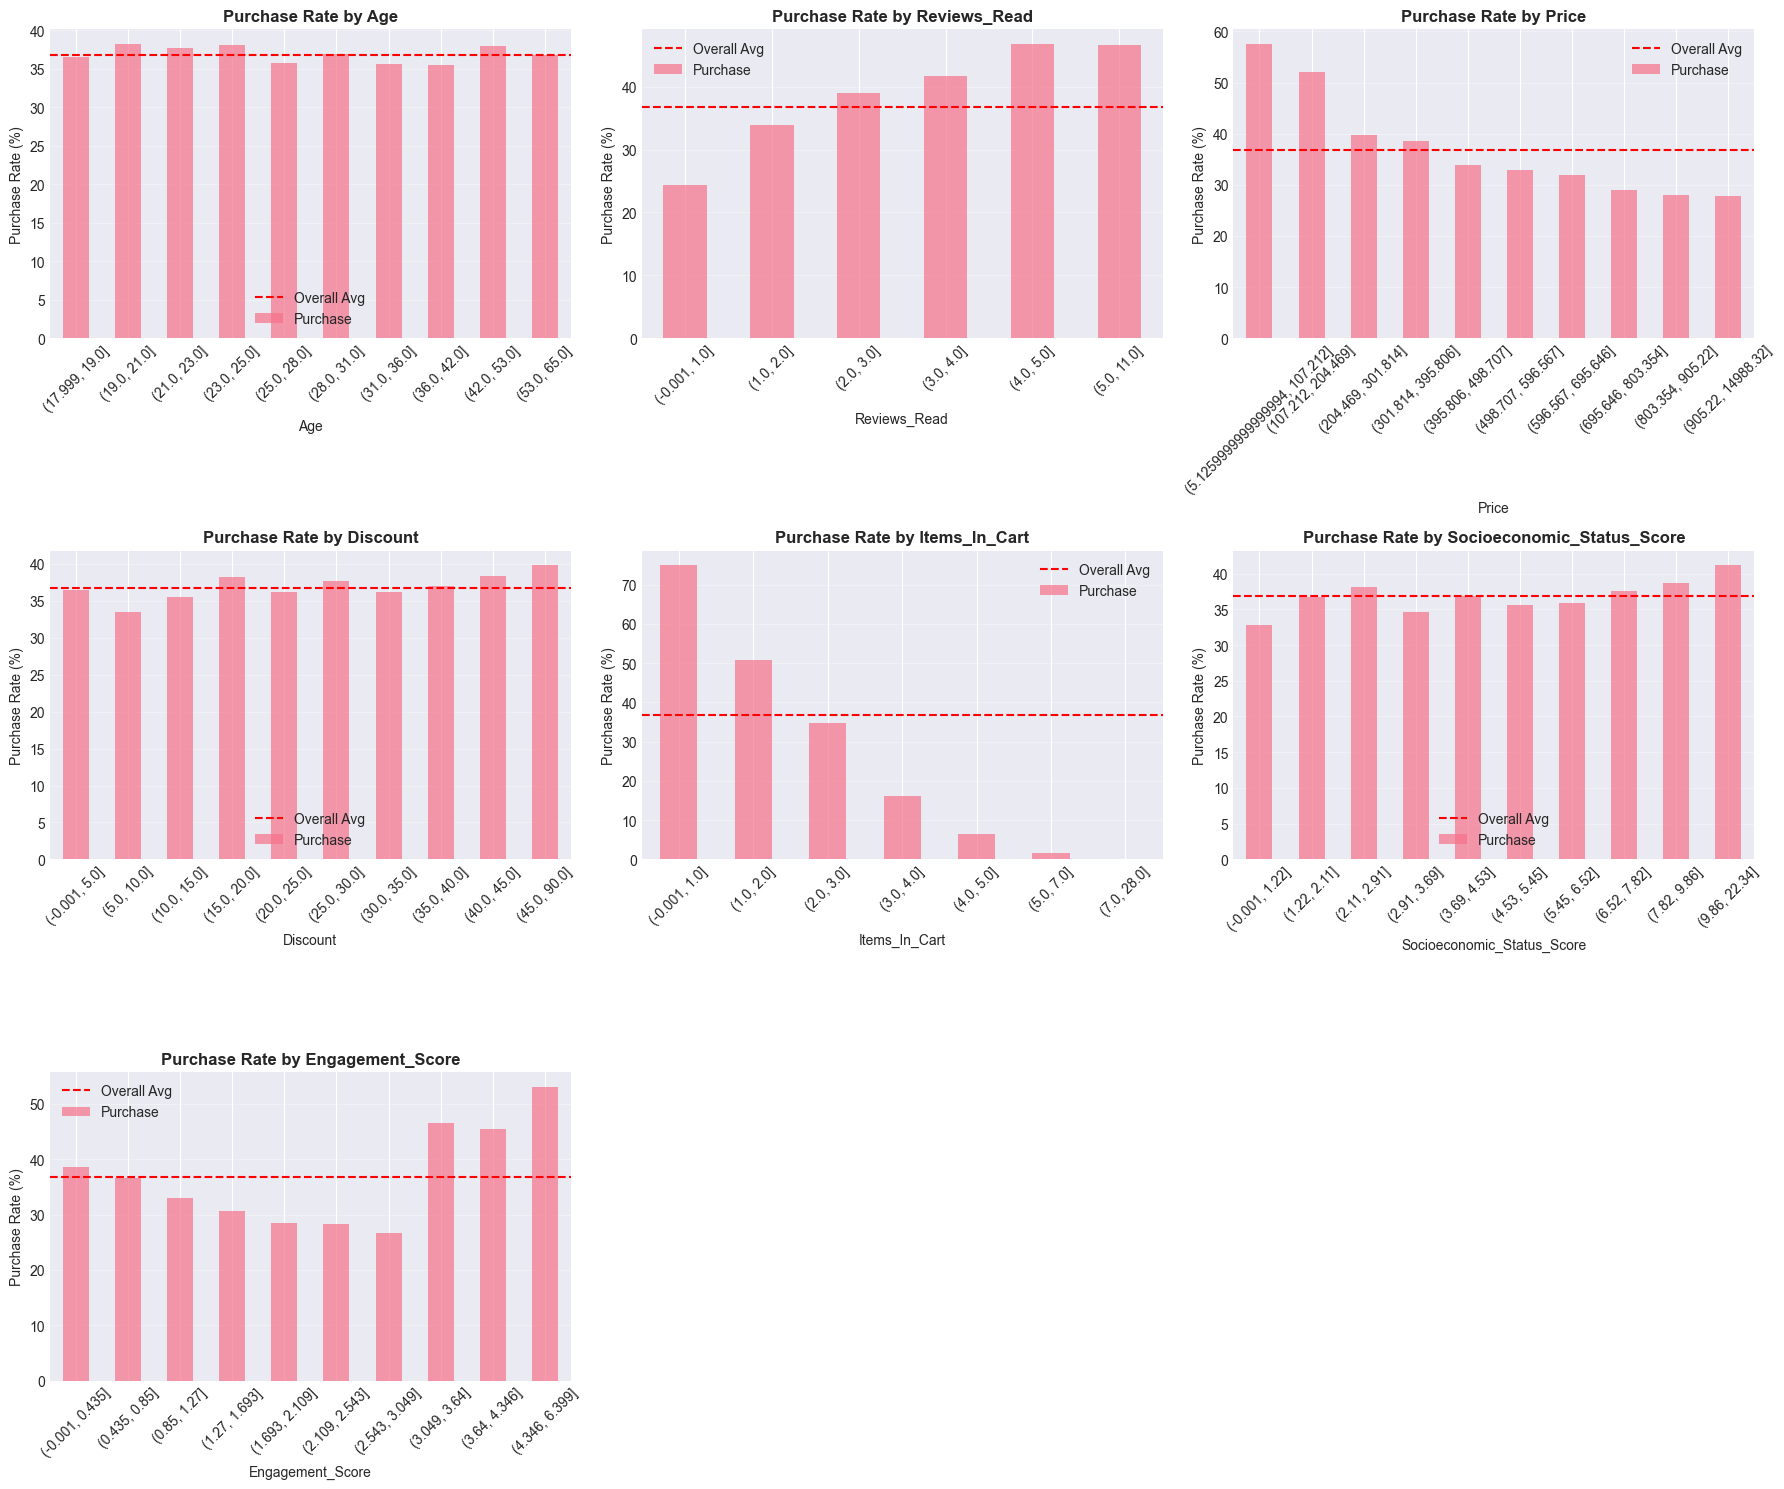

In [44]:
# Purchase rate by numerical features (binned)
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(numerical_features):
    # Create bins
    train_df[f'{col}_binned'] = pd.qcut(train_df[col], q=10, duplicates='drop')

    # Calculate purchase rate by bin
    purchase_by_bin = train_df.groupby(f'{col}_binned')['Purchase'].mean() * 100

    # Plot
    purchase_by_bin.plot(kind='bar', ax=axes[idx], alpha=0.7)
    axes[idx].set_title(f'Purchase Rate by {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Purchase Rate (%)')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].axhline(y=purchase_rate*100, color='r', linestyle='--', label='Overall Avg')
    axes[idx].legend()

    # Drop temporary column
    train_df.drop(f'{col}_binned', axis=1, inplace=True)

for idx in range(len(numerical_features), 9):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

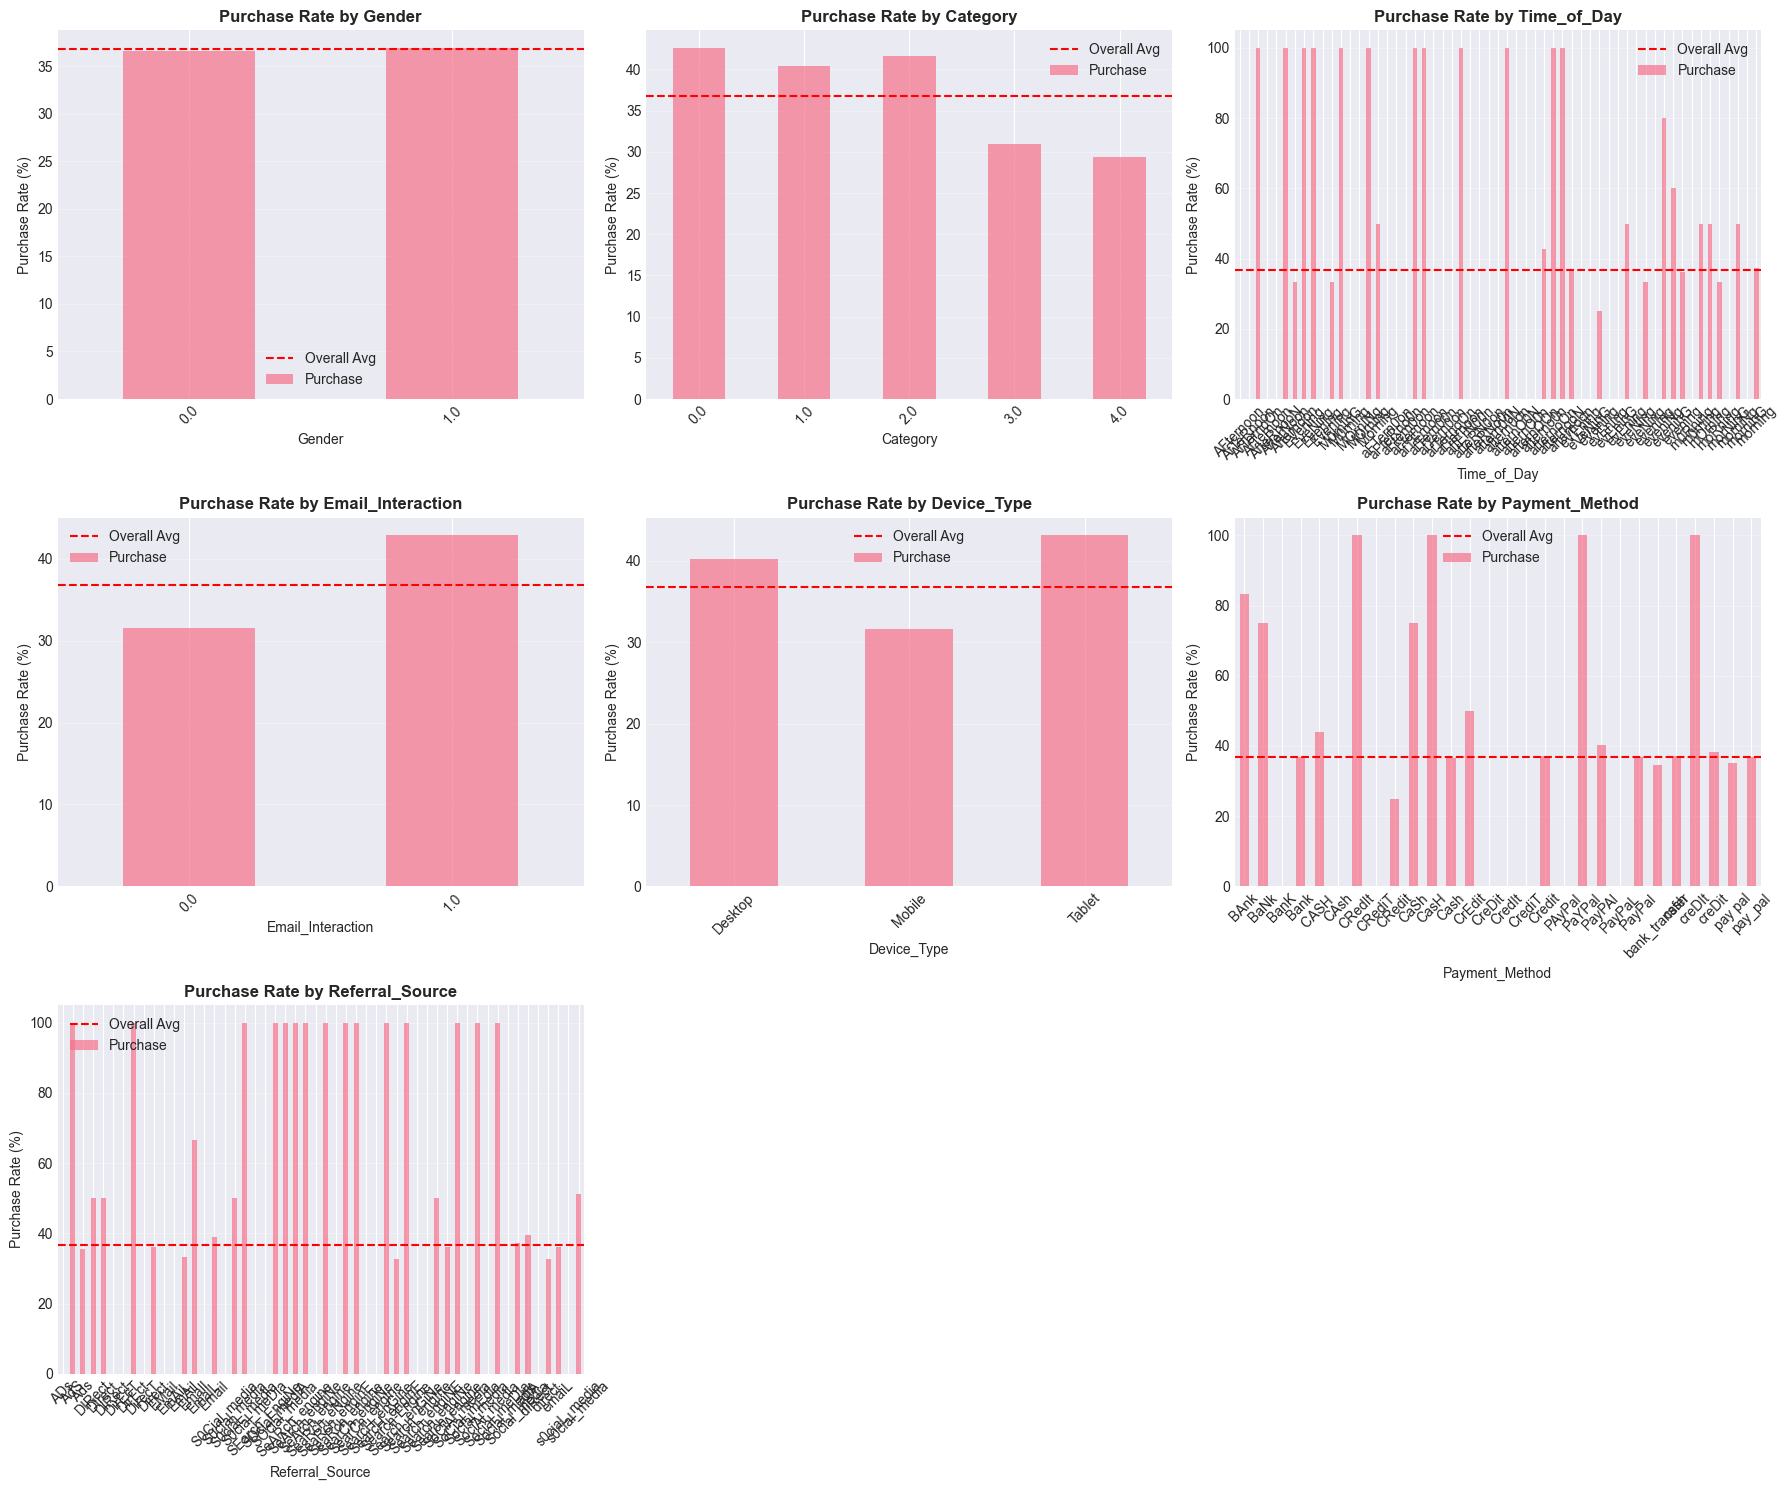

In [45]:
# Purchase rate by categorical features
fig, axes = plt.subplots(3, 3, figsize=(18, 15))
axes = axes.ravel()

for idx, col in enumerate(categorical_features):
    purchase_by_cat = train_df.groupby(col)['Purchase'].mean() * 100
    purchase_by_cat.plot(kind='bar', ax=axes[idx], alpha=0.7)
    axes[idx].set_title(f'Purchase Rate by {col}', fontsize=12, fontweight='bold')
    axes[idx].set_xlabel(col)
    axes[idx].set_ylabel('Purchase Rate (%)')
    axes[idx].tick_params(axis='x', rotation=45)
    axes[idx].grid(True, alpha=0.3, axis='y')
    axes[idx].axhline(y=purchase_rate*100, color='r', linestyle='--', label='Overall Avg')
    axes[idx].legend()

for idx in range(len(categorical_features), 9):
    fig.delaxes(axes[idx])

plt.tight_layout()
plt.show()

In [46]:
# Statistical tests for categorical features
from scipy.stats import chi2_contingency

print("Chi-square test results for categorical features:")
print("="*70)

for col in categorical_features:
    contingency_table = pd.crosstab(train_df[col], train_df['Purchase'])
    chi2, p_value, dof, expected = chi2_contingency(contingency_table)

    print(f"\n{col}:")
    print(f"  Chi-square statistic: {chi2:.4f}")
    print(f"  P-value: {p_value:.4e}")
    print(f"  Significant: {'Yes' if p_value < 0.05 else 'No'}")

Chi-square test results for categorical features:

Gender:
  Chi-square statistic: 0.1135
  P-value: 7.3619e-01
  Significant: No

Category:
  Chi-square statistic: 183.3602
  P-value: 1.4152e-38
  Significant: Yes

Time_of_Day:
  Chi-square statistic: 51.1357
  P-value: 6.5915e-01
  Significant: No

Email_Interaction:
  Chi-square statistic: 184.7512
  P-value: 4.4476e-42
  Significant: Yes

Device_Type:
  Chi-square statistic: 132.0296
  P-value: 2.1387e-29
  Significant: Yes

Payment_Method:
  Chi-square statistic: 29.5357
  P-value: 3.3541e-01
  Significant: No

Referral_Source:
  Chi-square statistic: 55.7212
  P-value: 3.0176e-01
  Significant: No


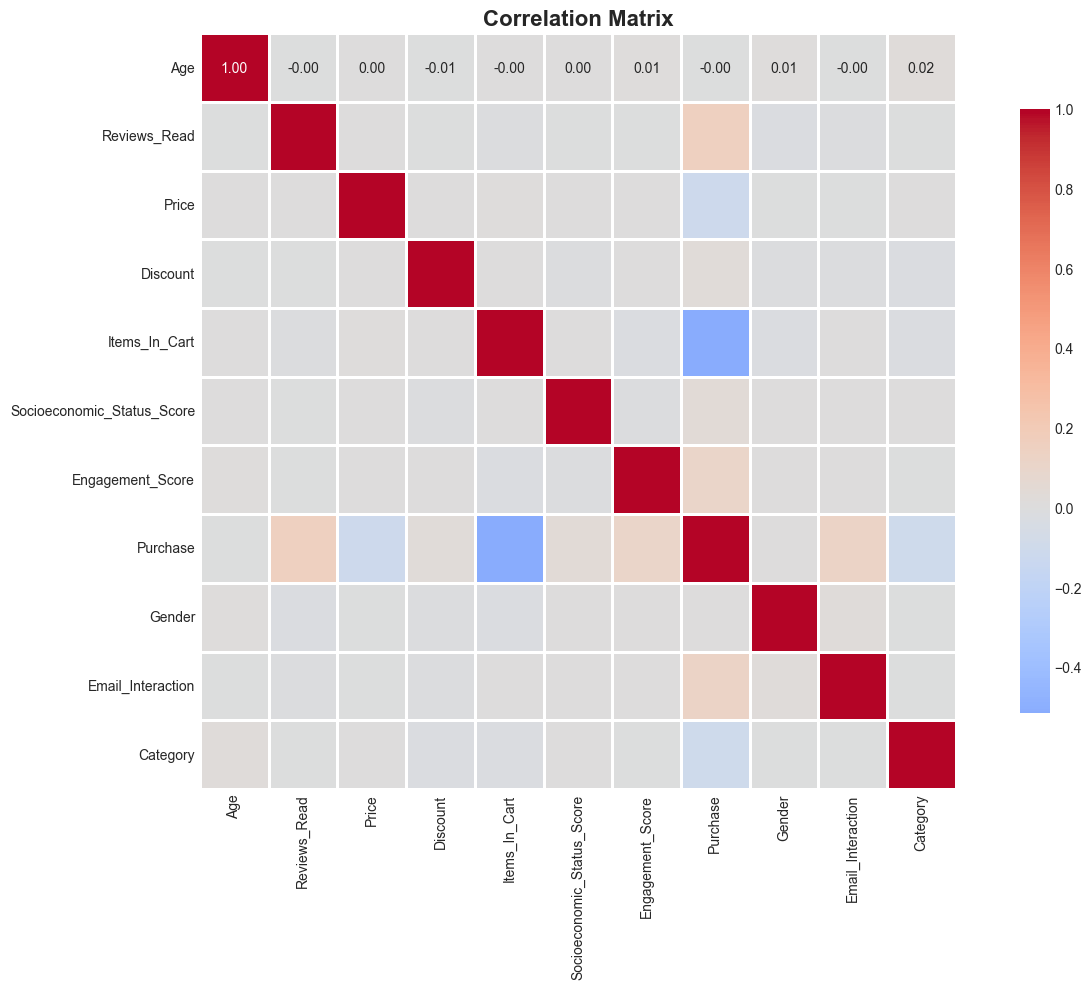

In [47]:
# Correlation matrix for numerical features
correlation_features = numerical_features + ['Purchase', 'Gender', 'Email_Interaction', 'Category']
corr_matrix = train_df[correlation_features].corr()

# Visualize
plt.figure(figsize=(14, 10))
sns.heatmap(corr_matrix, annot=True, fmt='.2f', cmap='coolwarm', center=0,
            square=True, linewidths=1, cbar_kws={"shrink": 0.8})
plt.title('Correlation Matrix', fontsize=16, fontweight='bold')
plt.tight_layout()
plt.show()

In [48]:
# Correlation with target variable
target_corr = corr_matrix['Purchase'].sort_values(ascending=False)
print("Correlation with Purchase:")
print("="*40)
print(target_corr)

Correlation with Purchase:
Purchase                      1.000000
Reviews_Read                  0.150997
Email_Interaction             0.117265
Engagement_Score              0.102906
Socioeconomic_Status_Score    0.039314
Discount                      0.025211
Gender                        0.003056
Age                          -0.002816
Category                     -0.105709
Price                        -0.112052
Items_In_Cart                -0.516965
Name: Purchase, dtype: float64


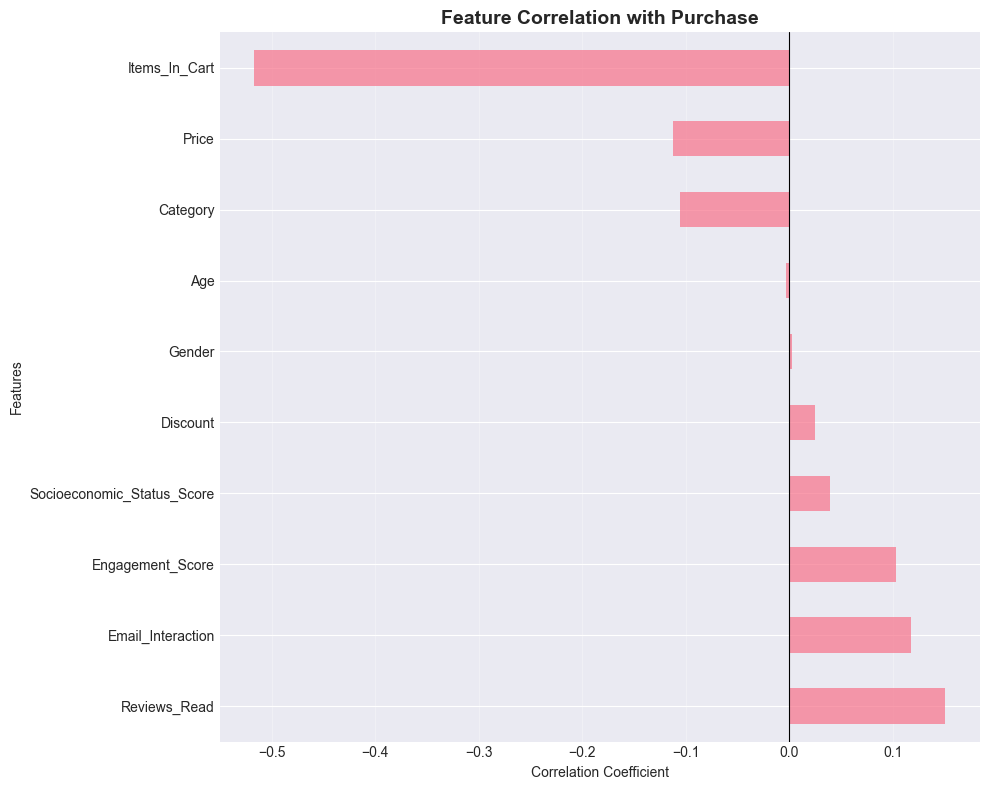

In [49]:
# Visualize correlations with target
plt.figure(figsize=(10, 8))
target_corr.drop('Purchase').plot(kind='barh', alpha=0.7)
plt.title('Feature Correlation with Purchase', fontsize=14, fontweight='bold')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Features')
plt.grid(True, alpha=0.3, axis='x')
plt.axvline(x=0, color='black', linestyle='-', linewidth=0.8)
plt.tight_layout()
plt.show()

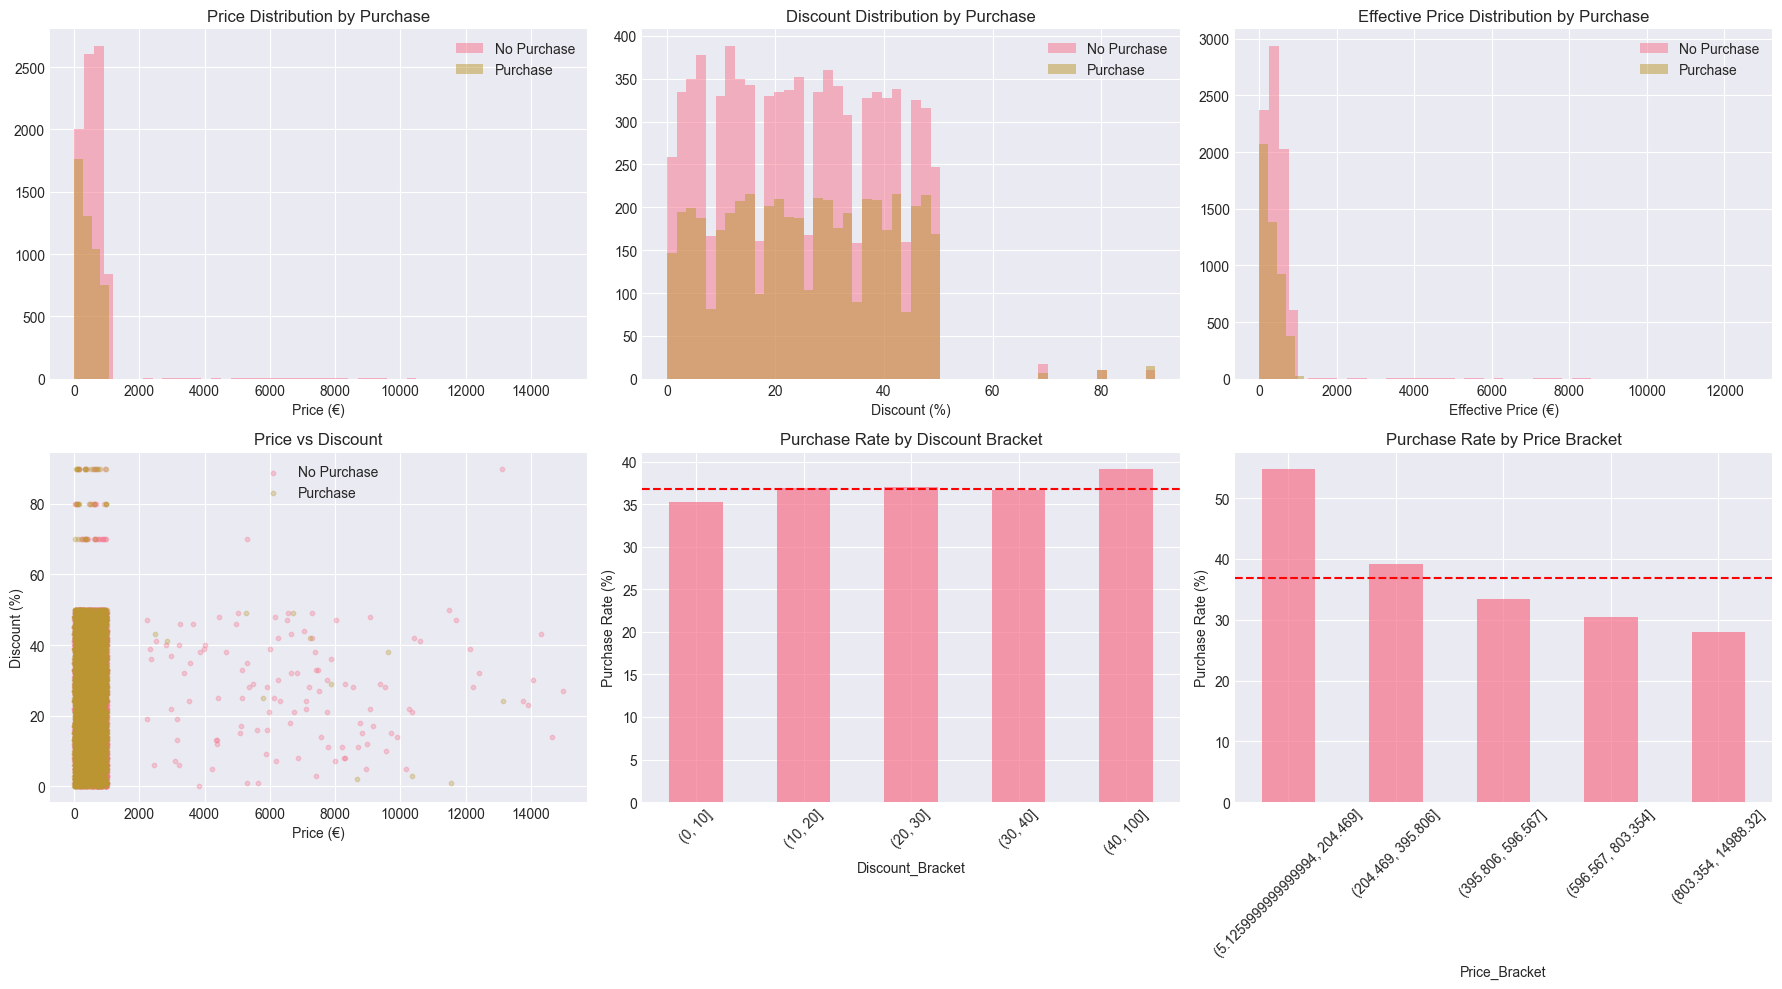

In [50]:
# Effective price (price after discount)
train_df['Effective_Price'] = train_df['Price'] * (1 - train_df['Discount'] / 100)

# Analyze price and discount effects
fig, axes = plt.subplots(2, 3, figsize=(18, 10))

# Price distribution by purchase
train_df[train_df['Purchase']==0]['Price'].hist(bins=50, alpha=0.5, label='No Purchase', ax=axes[0,0])
train_df[train_df['Purchase']==1]['Price'].hist(bins=50, alpha=0.5, label='Purchase', ax=axes[0,0])
axes[0,0].set_title('Price Distribution by Purchase')
axes[0,0].set_xlabel('Price (€)')
axes[0,0].legend()

# Discount distribution by purchase
train_df[train_df['Purchase']==0]['Discount'].hist(bins=50, alpha=0.5, label='No Purchase', ax=axes[0,1])
train_df[train_df['Purchase']==1]['Discount'].hist(bins=50, alpha=0.5, label='Purchase', ax=axes[0,1])
axes[0,1].set_title('Discount Distribution by Purchase')
axes[0,1].set_xlabel('Discount (%)')
axes[0,1].legend()

# Effective price distribution by purchase
train_df[train_df['Purchase']==0]['Effective_Price'].hist(bins=50, alpha=0.5, label='No Purchase', ax=axes[0,2])
train_df[train_df['Purchase']==1]['Effective_Price'].hist(bins=50, alpha=0.5, label='Purchase', ax=axes[0,2])
axes[0,2].set_title('Effective Price Distribution by Purchase')
axes[0,2].set_xlabel('Effective Price (€)')
axes[0,2].legend()

# Scatter plots
axes[1,0].scatter(train_df[train_df['Purchase']==0]['Price'],
                  train_df[train_df['Purchase']==0]['Discount'],
                  alpha=0.3, label='No Purchase', s=10)
axes[1,0].scatter(train_df[train_df['Purchase']==1]['Price'],
                  train_df[train_df['Purchase']==1]['Discount'],
                  alpha=0.3, label='Purchase', s=10)
axes[1,0].set_title('Price vs Discount')
axes[1,0].set_xlabel('Price (€)')
axes[1,0].set_ylabel('Discount (%)')
axes[1,0].legend()

# Purchase rate by discount brackets
train_df['Discount_Bracket'] = pd.cut(train_df['Discount'], bins=[0, 10, 20, 30, 40, 100])
discount_purchase = train_df.groupby('Discount_Bracket')['Purchase'].mean() * 100
discount_purchase.plot(kind='bar', ax=axes[1,1], alpha=0.7)
axes[1,1].set_title('Purchase Rate by Discount Bracket')
axes[1,1].set_ylabel('Purchase Rate (%)')
axes[1,1].tick_params(axis='x', rotation=45)
axes[1,1].axhline(y=purchase_rate*100, color='r', linestyle='--')

# Purchase rate by price brackets
train_df['Price_Bracket'] = pd.qcut(train_df['Price'], q=5, duplicates='drop')
price_purchase = train_df.groupby('Price_Bracket')['Purchase'].mean() * 100
price_purchase.plot(kind='bar', ax=axes[1,2], alpha=0.7)
axes[1,2].set_title('Purchase Rate by Price Bracket')
axes[1,2].set_ylabel('Purchase Rate (%)')
axes[1,2].tick_params(axis='x', rotation=45)
axes[1,2].axhline(y=purchase_rate*100, color='r', linestyle='--')

plt.tight_layout()
plt.show()

# Clean up temporary columns
train_df.drop(['Discount_Bracket', 'Price_Bracket'], axis=1, inplace=True)

In [51]:
def create_price_features(df):
    """
    Create features related to price and discount
    """
    df = df.copy()

    # Effective price after discount
    df['Effective_Price'] = df['Price'] * (1 - df['Discount'] / 100)

    # Discount amount in euros
    df['Discount_Amount'] = df['Price'] * df['Discount'] / 100

    # Price per item in cart
    df['Price_Per_Item'] = df['Price'] / (df['Items_In_Cart'] + 1)  # +1 to avoid division by zero

    # Binary: High discount (>30%)
    df['High_Discount'] = (df['Discount'] > 30).astype(int)

    # Binary: Has discount
    df['Has_Discount'] = (df['Discount'] > 0).astype(int)

    # Price categories
    df['Price_Category'] = pd.cut(df['Price'],
                                   bins=[0, 50, 200, 500, 10000],
                                   labels=['Low', 'Medium', 'High', 'Premium'])

    return df

# Test the function
train_with_price_features = create_price_features(train_df)
print("New price-related features created:")
print(train_with_price_features[['Price', 'Discount', 'Effective_Price', 'Discount_Amount',
                                  'Price_Per_Item', 'High_Discount', 'Has_Discount', 'Price_Category']].head())

New price-related features created:
     Price  Discount  Effective_Price  Discount_Amount  Price_Per_Item  \
0  592.975      22.0        462.52050        130.45450       84.710714   
1  511.279      12.0        449.92552         61.35348      127.819750   
2  218.360       2.0        213.99280          4.36720       43.672000   
3  313.781       1.0        310.64319          3.13781      313.781000   
4  495.088      13.0        430.72656         64.36144      165.029333   

   High_Discount  Has_Discount Price_Category  
0              0             1        Premium  
1              0             1        Premium  
2              0             1           High  
3              0             1           High  
4              0             1           High  


In [52]:
# Unique values and counts
print("Categories:", train_df['Category'].unique())
print(train_df['Category'].value_counts())


Categories: [ 1.  0.  3.  2.  4. nan]
1.0    2778
4.0    2771
0.0    2690
3.0    2612
2.0    2597
Name: Category, dtype: int64


In [53]:
cat_profile = train_df.groupby('Category')[numerical_features].mean().round(2)
cat_profile


,Age,Reviews_Read,Price,Discount,Items_In_Cart,Socioeconomic_Status_Score,Engagement_Score
Category,,,,,,,
0.0,31.58,2.99,561.57,25.32,3.51,5.11,2.25
1.0,31.45,3.01,557.12,25.51,3.63,5.04,2.28
2.0,32.54,2.99,556.80,25.06,3.50,5.18,2.30
3.0,32.37,2.97,560.36,24.86,3.46,5.19,2.30
4.0,31.87,2.98,566.62,24.76,3.45,5.09,2.22


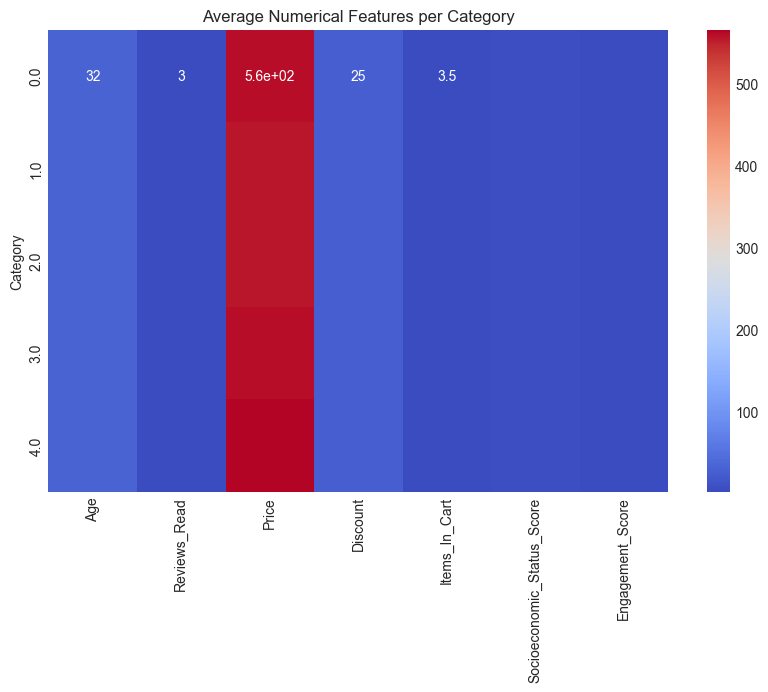

In [54]:
plt.figure(figsize=(10, 6))
sns.heatmap(cat_profile, annot=True, cmap='coolwarm')
plt.title("Average Numerical Features per Category")
plt.show()


In [55]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

X = StandardScaler().fit_transform(cat_profile)
kmeans = KMeans(n_clusters=3, random_state=42)
clusters = kmeans.fit_predict(X)

cat_profile['Cluster'] = clusters
cat_profile


,Age,Reviews_Read,Price,Discount,Items_In_Cart,Socioeconomic_Status_Score,Engagement_Score,Cluster
Category,,,,,,,,
0.0,31.58,2.99,561.57,25.32,3.51,5.11,2.25,2
1.0,31.45,3.01,557.12,25.51,3.63,5.04,2.28,0
2.0,32.54,2.99,556.80,25.06,3.50,5.18,2.30,1
3.0,32.37,2.97,560.36,24.86,3.46,5.19,2.30,1
4.0,31.87,2.98,566.62,24.76,3.45,5.09,2.22,2


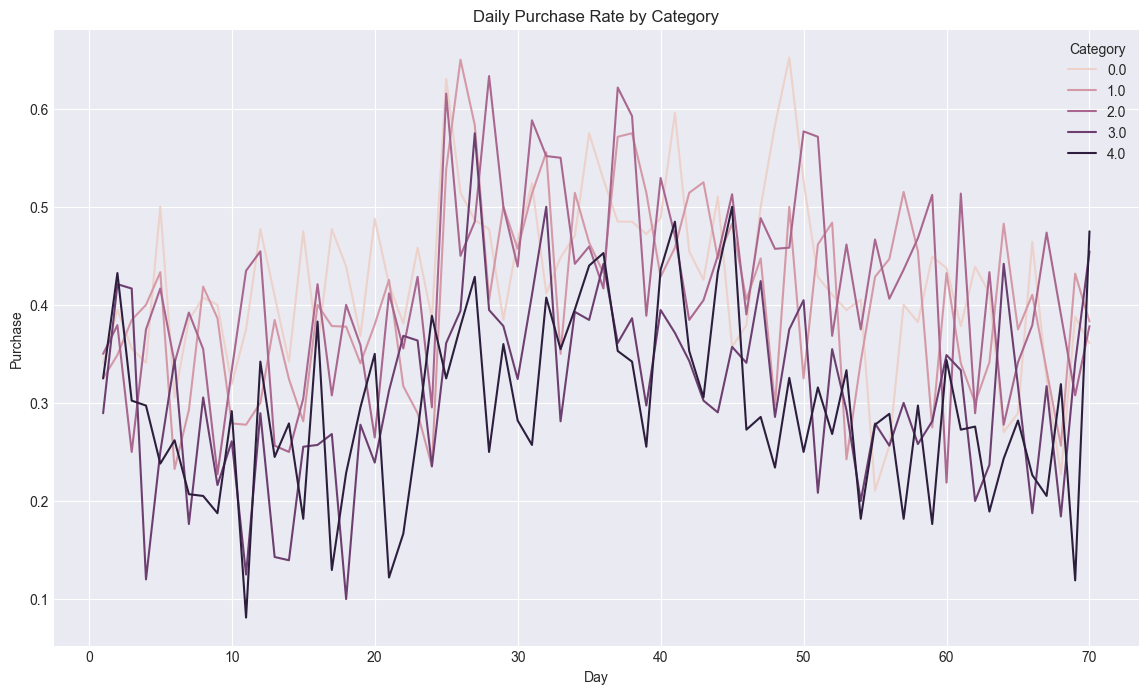

In [56]:
daily_cat = train_df.groupby(['Day', 'Category'])['Purchase'].mean().reset_index()

plt.figure(figsize=(14, 8))
sns.lineplot(data=daily_cat, x='Day', y='Purchase', hue='Category')
plt.title("Daily Purchase Rate by Category")
plt.show()


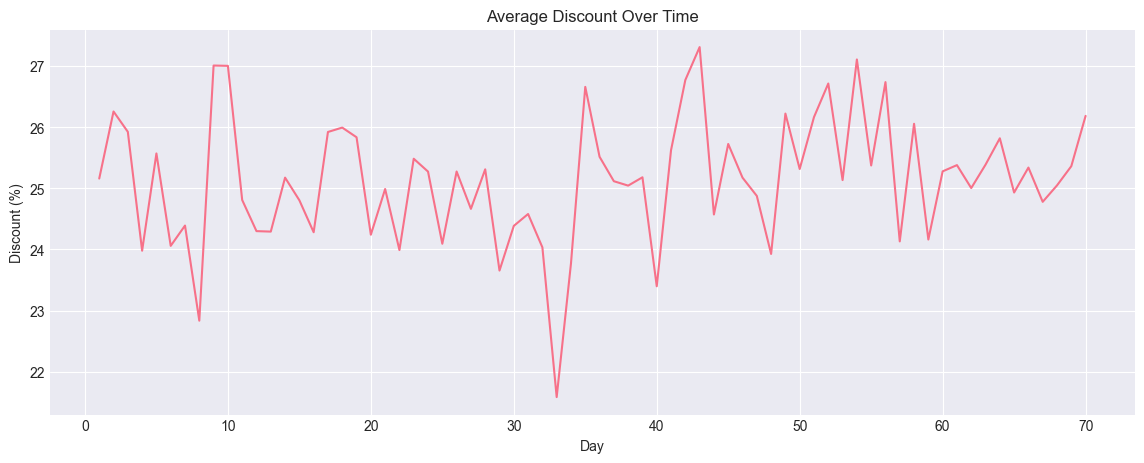

In [57]:
discount_time = train_df.groupby(['Day'])['Discount'].mean()

plt.figure(figsize=(14,5))
plt.plot(discount_time.index, discount_time.values)
plt.title("Average Discount Over Time")
plt.xlabel("Day")
plt.ylabel("Discount (%)")
plt.show()


In [58]:
campaign_cat = train_df.groupby(['Campaign_Period', 'Category'])['Purchase']\
                       .mean()\
                       .unstack()

campaign_cat


Category,0.0,1.0,2.0,3.0,4.0
Campaign_Period,,,,,
False,0.385299,0.359675,0.373750,0.271712,0.259672
True,0.496849,0.477250,0.489429,0.376310,0.348560


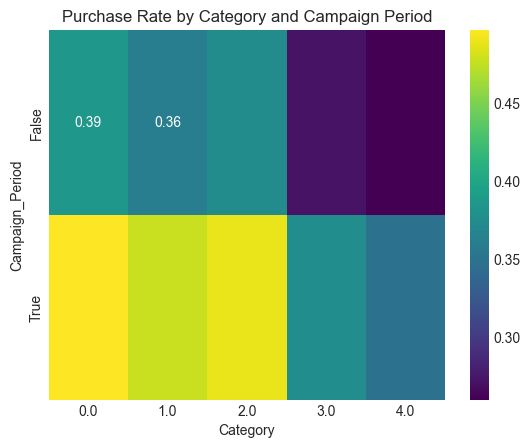

In [59]:
sns.heatmap(campaign_cat, annot=True, cmap="viridis")
plt.title("Purchase Rate by Category and Campaign Period")
plt.show()


In [ ]:
import statsmodels.formula.api as smf

for cat in train_df['Category'].unique():
    # 1. Create the subset
    sub = train_df[train_df['Category'] == cat].copy()

    # 2. CRITICAL: Check if the subset is empty
    if not sub.empty and len(sub) > 1:
        try:
            # Fit the model only if the subset is non-empty and has enough observations
            model = smf.logit('Purchase ~ Discount', data=sub).fit(disp=False)
            print(cat, model.params['Discount'])
        except Exception as e:
            # Optional: Catch other potential fitting errors (e.g., perfect separation)
            print(f"Skipping category {cat}: Error during model fitting - {e}")
    else:
        print(f"Skipping category {cat}: Subset is empty or has only one observation.")

1.0 0.0074750216086152885
0.0 0.0036728221943534826
3.0 -0.0006528060004452228
2.0 0.0031699033328477714
4.0 0.002268936014159705
Skipping category nan: Subset is empty or has only one observation.


In [ ]:
# # Interpretation (short):

# These are log-odds slopes (β per 1 percentage point of discount).

# Convert to % change in odds of purchase per 1ppt discount: exp(β)-1. I computed these for you:

# Category 1: β = 0.007475 → odds increase ≈ +0.75% per 1% discount

# Category 0: β = 0.003673 → odds increase ≈ +0.37% per 1% discount

# Category 3: β = -0.000653 → odds decrease ≈ −0.07% per 1% discount (essentially zero)

# Category 2: β = 0.003170 → odds increase ≈ +0.32% per 1% discount

# Category 4: β = 0.002269 → odds increase ≈ +0.23% per 1% discount

# Business meaning:

# The magnitudes are small — a 10% discount on category 1 increases the odds of purchase by ≈ 7.5% (not 7.5 percentage points, but 7.5% increase in odds). That’s a modest effect.

# Category 3 shows effectively no positive response to discount (slightly negative → probably noise).

# So: discounts are not a huge lever overall, but there is a measurable response in some categories (esp category 1). Whether it’s “worth it” depends on margin and cost structure.

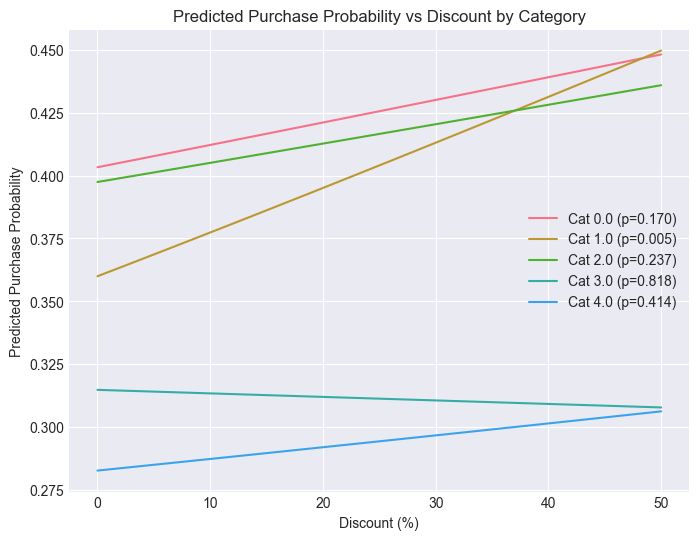

In [85]:
import statsmodels.formula.api as smf
import numpy as np
import matplotlib.pyplot as plt

cats = sorted(train_df['Category'].unique())
fig, ax = plt.subplots(figsize=(8,6))
disc_range = np.linspace(0,50,51)

for cat in cats:
    sub = train_df[train_df['Category']==cat]
    if len(sub) < 50:  # skip very small groups
        continue
    model = smf.logit('Purchase ~ Discount', data=sub).fit(disp=False)
    coef = model.params['Discount']
    pval = model.pvalues['Discount']
    probs = model.predict(exog=dict(Discount=disc_range, Intercept=1))
    # statsmodels logistic with formula: to predict properly use model.predict with a DataFrame:
    import pandas as pd
    df_pred = pd.DataFrame({'Discount':disc_range})
    preds = model.predict(df_pred)
    ax.plot(disc_range, preds, label=f'Cat {cat} (p={pval:.3f})')
ax.set_xlabel('Discount (%)')
ax.set_ylabel('Predicted Purchase Probability')
ax.legend()
plt.title('Predicted Purchase Probability vs Discount by Category')
plt.show()
# Category 4 is just missing values

In [86]:
train_df2 = create_price_features(train_df)


In [87]:
pd.pivot_table(
    train_df2,
    values='Purchase',
    index='Price_Category',
    columns='Category',
    aggfunc='mean'
)


Category,0.0,1.0,2.0,3.0,4.0
Price_Category,,,,,
Low,0.593407,0.559055,0.672566,0.563636,0.500000
Medium,0.586902,0.552941,0.587393,0.504132,0.482234
High,0.423126,0.430000,0.444872,0.314888,0.275990
Premium,0.370342,0.333852,0.331971,0.239028,0.235249


In [88]:
#THe price Category is most Premium for category 1 and lowest for category 2. Otherwise it is similar for meidum and high price_category between the other features

    Category Device_Type_clean Time_of_Day_clean  Purchase
14       0.0            tablet          afternon  1.000000
9        0.0            mobile            mrning  1.000000
65       3.0               nan          afternon  1.000000
58       3.0           desktop            mrning  1.000000
88       4.0               nan               nan  1.000000
5        0.0            mobile          afternon  0.666667
48       2.0               nan           morning  0.666667
11       0.0               nan         afternoon  0.666667
22       1.0           desktop               nan  0.647059
34       1.0            tablet               nan  0.571429
4        0.0           desktop               nan  0.571429
51       2.0            tablet           morning  0.549020
31       1.0            tablet         afternoon  0.547826
87       4.0               nan           morning  0.541667
15       0.0            tablet         afternoon  0.530973
17       0.0            tablet           morning  0.5193

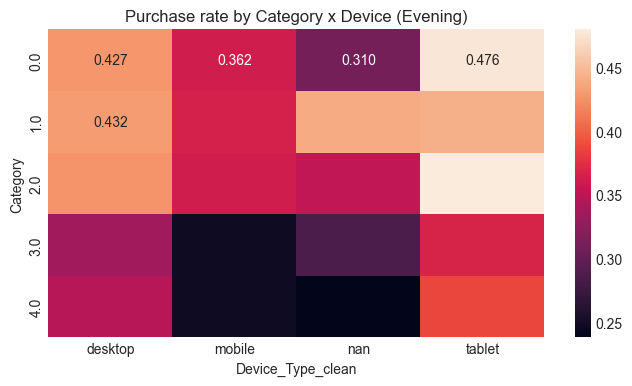

In [90]:
# normalize strings
train_df['Time_of_Day_clean'] = train_df['Time_of_Day'].astype(str).str.lower().str.strip().str.replace(r'[^a-z]','', regex=True)
train_df['Device_Type_clean'] = train_df['Device_Type'].astype(str).str.lower().str.strip()

# map common variants if needed (example)
train_df['Time_of_Day_clean'] = train_df['Time_of_Day_clean'].replace({
    'afternoon': 'afternoon', 'afternoon': 'afternoon', 'aftern0on': 'afternoon',
    'evening': 'evening', 'evning': 'evening', 'eveng': 'evening', 'morning': 'morning'
    # add any mapping you discover
})

# create pivot: purchase rate
pivot = train_df.groupby(['Category','Device_Type_clean','Time_of_Day_clean'])['Purchase'].mean().reset_index()
# sort by highest conversion to inspect top segments
top_segments = pivot.sort_values('Purchase', ascending=False).head(20)
print(top_segments)

# heatmap example for Category x Device_Type for a single time_of_day (e.g., 'evening')
heat = train_df[train_df['Time_of_Day_clean']=='evening'].groupby(['Category','Device_Type_clean'])['Purchase'].mean().unstack(fill_value=0)
import seaborn as sns, matplotlib.pyplot as plt
plt.figure(figsize=(8,4))
sns.heatmap(heat, annot=True, fmt='.3f')
plt.title('Purchase rate by Category x Device (Evening)')
plt.show()


In [65]:
train_df.groupby(['Category', 'Campaign_Period'])['Purchase'].mean().unstack()


Campaign_Period,False,True
Category,,
0.0,0.385299,0.496849
1.0,0.359675,0.477250
2.0,0.373750,0.489429
3.0,0.271712,0.376310
4.0,0.259672,0.348560


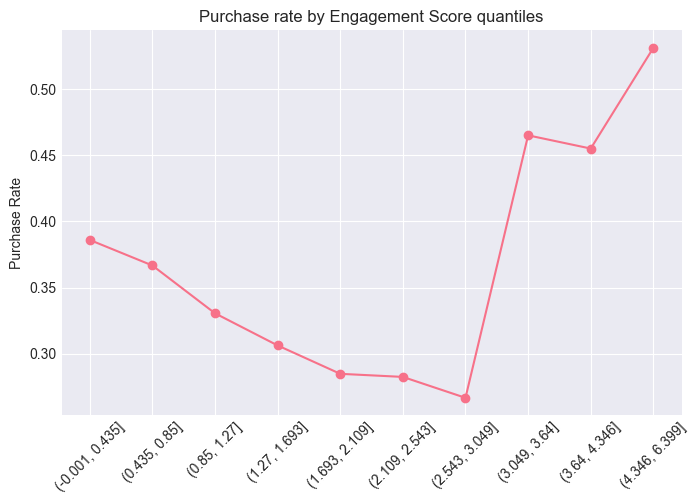

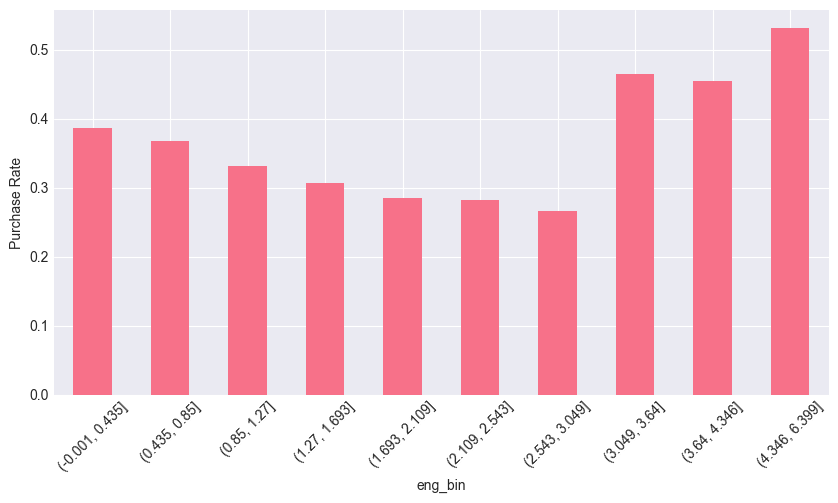

In [91]:
# If Engagement_Score is continuous:
train_df['eng_bin'] = pd.qcut(train_df['Engagement_Score'], q=10, duplicates='drop')
eng_by_bin = train_df.groupby('eng_bin')['Purchase'].agg(['mean','count']).reset_index()

# plot mean purchase per bin with counts as size
import matplotlib.pyplot as plt
plt.figure(figsize=(8,5))
plt.plot(range(len(eng_by_bin)), eng_by_bin['mean'], marker='o')
plt.xticks(range(len(eng_by_bin)), eng_by_bin['eng_bin'].astype(str), rotation=45)
plt.ylabel('Purchase Rate')
plt.title('Purchase rate by Engagement Score quantiles')
plt.grid(True)
plt.show()

# Bar chart with counts annotated
eng_by_bin.plot(x='eng_bin', y='mean', kind='bar', legend=False, figsize=(10,5))
plt.ylabel('Purchase Rate')
plt.xticks(rotation=45)
plt.show()


In [92]:
# THe more engaged they are the more they are likely to buy. Could be a segment to specifically target

In [89]:
pivot = train_df.groupby(['Category','Campaign_Period'])['Purchase'].mean().unstack()
pivot['uplift_abs'] = pivot[True] - pivot[False]
pivot['uplift_rel_pct'] = (pivot[True] / pivot[False] - 1) * 100
print(pivot.sort_values('uplift_abs', ascending=False))


Campaign_Period     False      True  uplift_abs  uplift_rel_pct
Category                                                       
1.0              0.359675  0.477250    0.117575       32.689308
2.0              0.373750  0.489429    0.115679       30.950950
0.0              0.385299  0.496849    0.111549       28.951357
3.0              0.271712  0.376310    0.104598       38.495927
4.0              0.259672  0.348560    0.088888       34.231037


In [74]:
base_rate = train_df[train_df['Discount'] == 0].groupby('Category')['Purchase'].mean()
base_rate

Category
0.0    0.484848
1.0    0.361111
2.0    0.375000
3.0    0.095238
4.0    0.241379
Name: Purchase, dtype: float64

In [ ]:
# Category 0 has ~48% purchase rate without discount — very high: likely these are users who convert naturally; don’t waste promotions on them.

# Category 3 is very low (~9.5%) — they rarely convert unless something special happens (campaign/discount/other).

# Categories 1–2 are moderate.

# Business takeaway:

# Do not target category 0 users with ads (high organic conversion) — save those ad-euros for categories with low baseline but big uplift under campaign.

# Category 3 might need a different strategy (product changes, higher discount, different creative or retargeting).

In [76]:
drift = train_df.groupby('Day')[['Price','Discount','Items_In_Cart']].mean()
drift

,Price,Discount,Items_In_Cart
Day,,,
1,491.805967,25.160976,3.653846
2,568.896531,26.258242,3.331522
3,507.801175,25.925532,3.566138
4,563.024614,23.980198,3.666667
5,523.422405,25.571429,3.708333
6,565.878399,24.059406,3.570000
7,533.217832,24.391534,3.783069
8,479.208631,22.835227,3.779661
9,553.471946,27.010417,3.440415


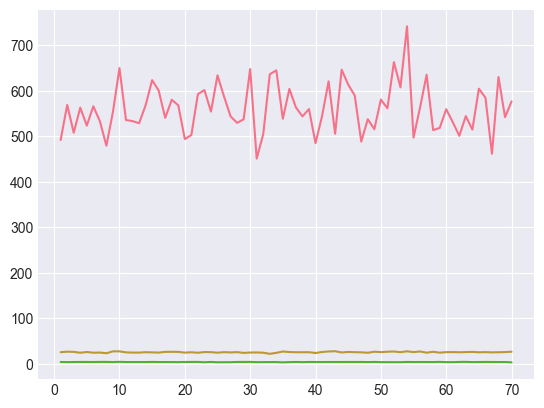

In [77]:
plt.plot(drift)

In [80]:
(train_df.groupby('Engagement_Score')['Purchase'].mean())


Engagement_Score
0.000000    0.368421
0.023979    0.142857
0.024849    0.000000
0.025649    0.000000
0.026391    0.000000
              ...   
6.270623    0.000000
6.280442    0.000000
6.312960    1.000000
6.329721    1.000000
6.398595    0.250000
Name: Purchase, Length: 10125, dtype: float64

In [81]:
train_df.groupby(['Email_Interaction', 'Category'])['Purchase'].mean()

Email_Interaction  Category
0.0                0.0         0.366573
                   1.0         0.350806
                   2.0         0.362392
                   3.0         0.253400
                   4.0         0.252362
1.0                0.0         0.492981
                   1.0         0.465475
                   2.0         0.479487
                   3.0         0.371257
                   4.0         0.339822
Name: Purchase, dtype: float64

In [94]:
# Email_Interaction = 1 corresponds to higher purchase rates across all categories (e.g., Cat0: 49.3% vs 36.7%).

# Email engagement is a strong positive signal. Good: it's cheap to check and useful for scoring.

# Actionable rule idea:

# Boost target score for sessions with Email_Interaction == 1. For example, one playbook rule could be:

# “If model score ≥ 0.6 OR Email_Interaction == 1 AND Category in {0,1,2} → target.”

# But prefer using Email_Interaction as a feature in the model rather than a hard rule alone.

In [82]:
train_df.groupby('Items_In_Cart')['Purchase'].mean()


Items_In_Cart
0.0     0.850123
1.0     0.695934
2.0     0.508299
3.0     0.347507
4.0     0.161061
5.0     0.065969
6.0     0.022700
7.0     0.006920
8.0     0.002326
9.0     0.003663
10.0    0.000000
11.0    0.000000
12.0    0.000000
13.0    0.000000
14.0    0.000000
15.0    0.000000
16.0    0.000000
17.0    0.000000
18.0    0.000000
19.0    0.000000
20.0    0.000000
21.0    0.000000
22.0    0.000000
25.0    0.000000
28.0    0.000000
Name: Purchase, dtype: float64

In [95]:
# show counts per Items_In_Cart to assess sample size
counts = train_df['Items_In_Cart'].value_counts().sort_index()
rates = train_df.groupby('Items_In_Cart')['Purchase'].agg(['mean','count'])
print(rates.head(20))

# check if Items_In_Cart correlates with Purchase time or other fields that leak
leak_check = train_df.groupby('Items_In_Cart')[['Price','Effective_Price','Purchase']].describe().transpose()
print(rates)


                   mean  count
Items_In_Cart                 
0.0            0.850123   1221
1.0            0.695934   2312
2.0            0.508299   2410
3.0            0.347507   2046
4.0            0.161061   1546
5.0            0.065969   1243
6.0            0.022700    837
7.0            0.006920    578
8.0            0.002326    430
9.0            0.003663    273
10.0           0.000000    191
11.0           0.000000    120
12.0           0.000000     83
13.0           0.000000     60
14.0           0.000000     33
15.0           0.000000     33
16.0           0.000000     12
17.0           0.000000     10
18.0           0.000000      7
19.0           0.000000      4
                   mean  count
Items_In_Cart                 
0.0            0.850123   1221
1.0            0.695934   2312
2.0            0.508299   2410
3.0            0.347507   2046
4.0            0.161061   1546
5.0            0.065969   1243
6.0            0.022700    837
7.0            0.006920    578
8.0     

In [96]:
# Items in cart has lots of leakage and is not a good signal it seems for our model

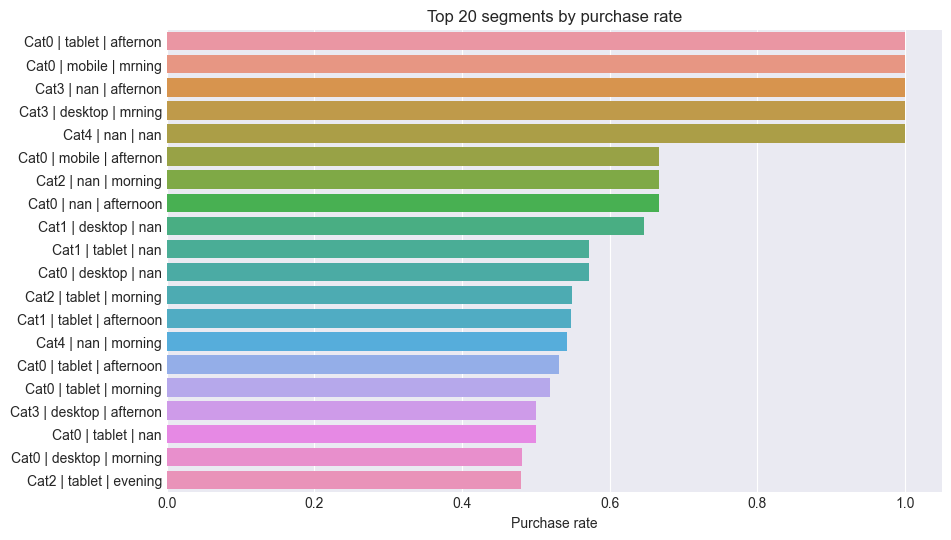

In [97]:
pivot = train_df.groupby(['Category','Device_Type_clean','Time_of_Day_clean'])['Purchase'].mean().reset_index()
top = pivot.sort_values('Purchase', ascending=False).head(20)
plt.figure(figsize=(10,6))
sns.barplot(data=top, x='Purchase', y=top.apply(lambda r: f"Cat{int(r['Category'])} | {r['Device_Type_clean']} | {r['Time_of_Day_clean']}", axis=1))
plt.title('Top 20 segments by purchase rate')
plt.xlabel('Purchase rate')
plt.show()


In [98]:
# Here are the best segments